# Kaitlyn Shin
## Physics 260
## Final project, due: March 24, 2017

The two projects I selected were Project 2 (stellar evolution models) and Project 3 (exoplanets). They will be presented in that order; in the interest of transparency, all relevant code is included.

Below are the imports I will be using throughout the code.

In [1]:
import numpy as np, matplotlib.pyplot as plt, astropy.constants
from astropy.io import ascii as asc
from astropy import units as u
from astropy.table import Table
from datetime import date
from matplotlib.pyplot import cm 
from scipy import optimize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Project 2: Generating and assessing stellar evolution models

All files come from the Wisconsin stellar evolution server *mad star*.

This project involved keeping track of a lot of tabled data. When reading the given ASCII files with astropy.io, the column names wouldn't read in correctly. Rather than modify each file individually, I simply wrote code to add the column names for me.

I generated a detailed structure file for the sun at its current age using *mad star*. I read in the file below.

In [2]:
file_cols = np.array(['M_r', 'r', 'L_r', 'P', 'rho', 'T', 'U', 'S', 'C_P', 'gamma_1', 'grad_ad',
                      'mu', 'n_e', 'P_e', 'P_r', 'grad_rad', 'grad', 'v_c', 'kappa', 'eps_nuc',
                      'eps_PP', 'eps_CNO', 'eps_3alpha', 'eps_nu,nuc', 'eps_nu', 'eps_grav',
                      'X', '-', 'X+', 'Y', 'Y+', 'Y++', 'X_C', 'X_N', 'X_O', 'psi'])
summary_cols = np.array(['i', 't', 'M', 'Log10(L)', 'Log10(R)', 'Log10(T_s)', 'Log10(T_c)',
                         'Log10(rho_c)', 'Log10(P_c)', 'psi_c', 'X_c', 'Y_c', 'X_C,c', 'X_N,c',
                         'X_O,c', 'tau_dyn', 'tau_KH', 'tau_nuc', 'L_PP', 'L_CNO', 'L_3alpha',
                         'L_Z', 'L_nu', 'M_He', 'M_C', 'M_O', 'R_He', 'R_C', 'R_O'])

summary = asc.read('ezweb_00344/summary.txt', guess=False, delimiter=' ', 
                   Reader=asc.FastNoHeader)
summary = Table(summary, names=summary_cols)
age = np.array(summary['t'])

Assuming our sun is currently 4.5e9 years old, I find the age of the star in the generated files closest to this current age. Using this star model, I then create (appropriately labeled) plots for temperature, opacity, pressure, density, and e_nuc vs radius.

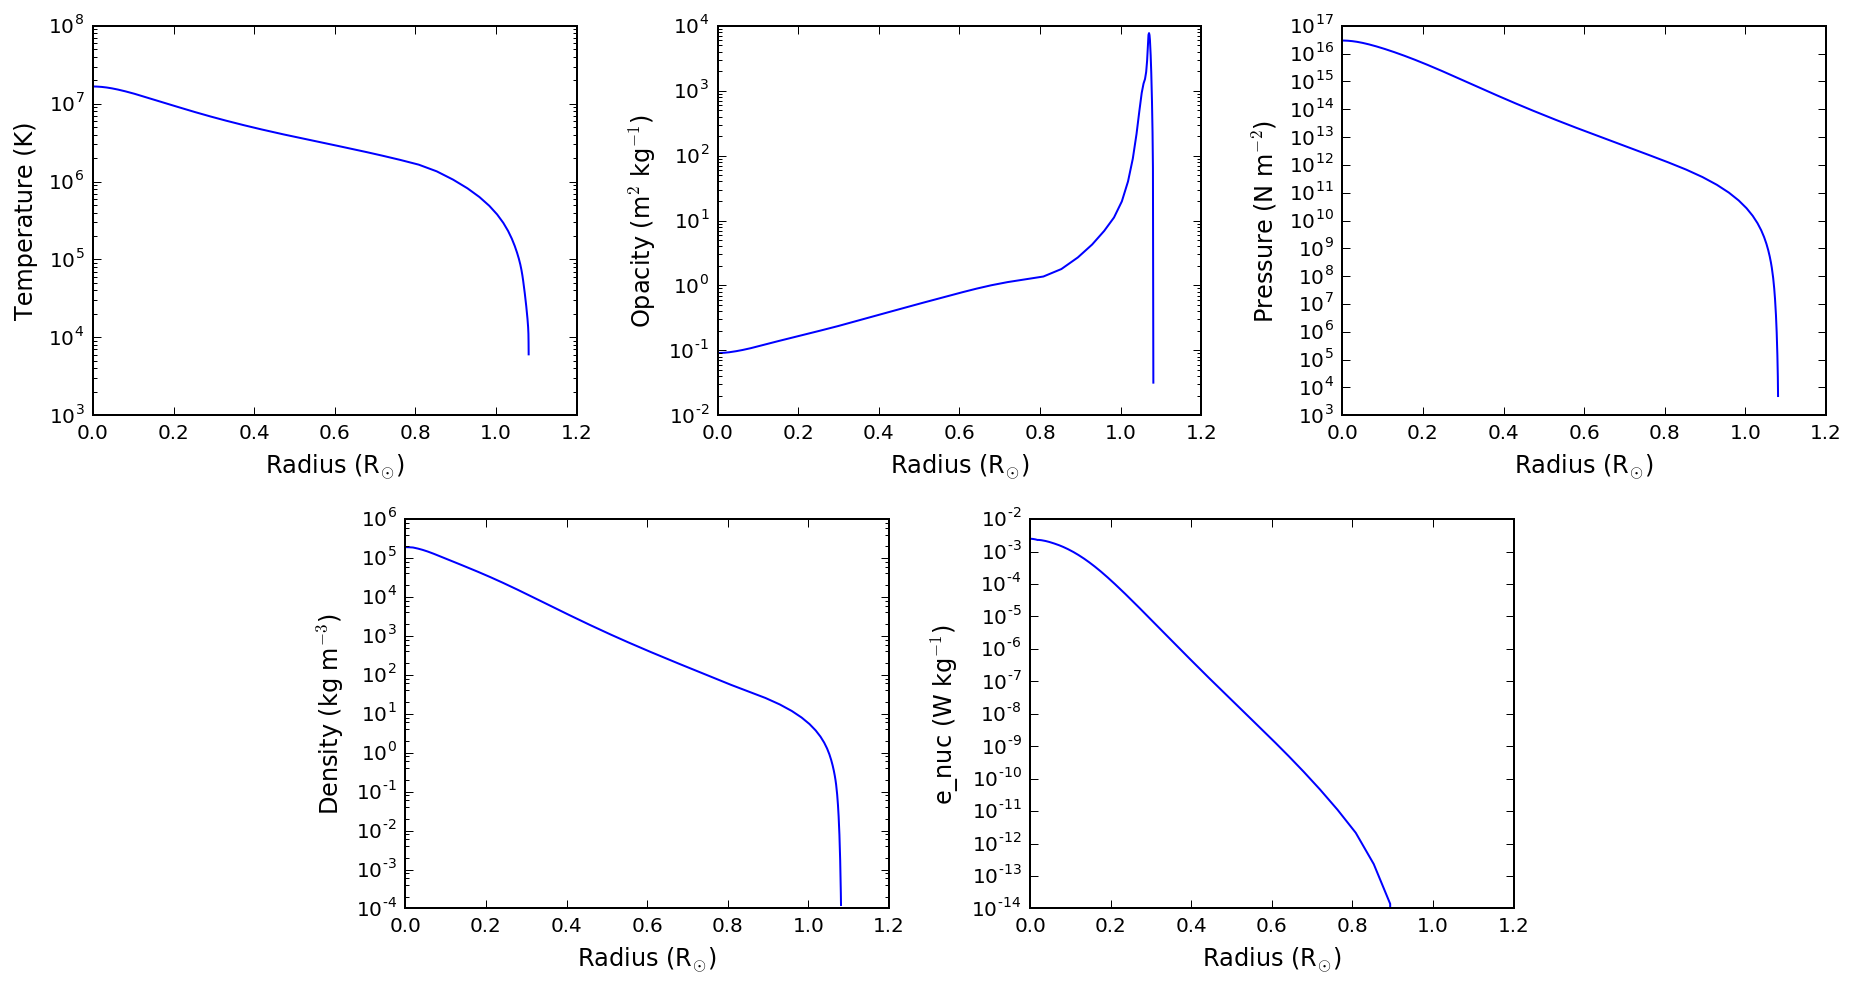

In [3]:
curr_i = min(range(len(age)), key=lambda i: abs(age[i]-4.5e9))
curr_star = asc.read('ezweb_00344/structure_'+str(curr_i).zfill(5)+'.txt', guess=False,
                     delimiter=' ', Reader=asc.FastNoHeader)
curr_star = Table(curr_star, names=file_cols)

radius = np.array(curr_star['r'])
temp = np.array(curr_star['T'])
opacity = np.array(curr_star['kappa'])
pressure = np.array(curr_star['P'])
density = np.array(curr_star['rho'])
e_nuc = np.array(curr_star['eps_nuc'])

# plotting
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ylabel_arr = ['Temperature (K)', 'Opacity (m'+r'$^2$'+' kg'+r'$^{-1}$'+')',
              'Pressure (N m'+r'$^{-2}$'+')', 'Density (kg m'+r'$^{-3}$'+')',
              'e_nuc (W kg'+r'$^{-1}$'+')']

for (ax, yarr, ylabel) in zip([ax1,ax2,ax3,ax4,ax5], 
                              [temp, opacity, pressure, density, e_nuc], ylabel_arr):
    ax.plot(radius, yarr)
    ax.set_xlabel('Radius (R'+r'$_{\odot}$'+')', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_yscale('log')
plt.gcf().set_size_inches(13,7)
plt.tight_layout()

There are some discrepancies in the above graph that are likely due to the finite resolution of the output files. For example, in the temperature-radius graph, there isn't a discernable leveling-off of temperature around the regions of convection. This is confirmed by the opacity-radius graph, as opacity never dips to zero before reaching its maximum. (Based on the equation of radiative energy transport, dT/dr = 0 when opacity = 0.)

Below, I verify that the star approximately satisfies hydrostatic equilibrium and the equation of radiative energy transport. I numerically estimate the required derivatives by computing derivatives on the left-hand sides of the equations and comparing them against the results on the right-hand sides of the equations (using average values of consecutive regions).

In [4]:
# approach:
#  dP_r/dr = (P_(i+1)-P_i)/(r_(i+1)-r_i)
#  M_avg = (M_i + M_(i+1))/2

# want everything in mks units
a = 7.5657e-16 # J m^-3 K^-4
c = 3e8 # m s^-2
G = astropy.constants.G.value

r = np.array(curr_star['r'])*6.95700e8 # m
P = np.array(curr_star['P']) # N m^-2
T = np.array(curr_star['T']) # K
rho = np.array(curr_star['rho']) # kg m^-3
L_r = np.array(curr_star['L_r'])*3.828e26 # W
kap = np.array(curr_star['kappa']) # m^2 kg^-1
M = np.array(curr_star['M_r'])*1.989e30 # kg

(dr, dP, dT, rho_avg, r_avg, T_avg, L_r_avg, 
 kap_avg, M_avg) = ([], [], [], [], [], [], [], [], [])
for i in range(len(r)-1):
    dr.append(r[i+1]-r[i])
    dP.append(P[i+1]-P[i])
    dT.append(T[i+1]-T[i])
    rho_avg.append((rho[i+1]+rho[i])/2)
    r_avg.append((r[i+1]+r[i])/2)
    T_avg.append((T[i+1]+T[i])/2)
    L_r_avg.append((L_r[i+1]+L_r[i])/2)
    kap_avg.append((kap[i+1]+kap[i])/2)
    M_avg.append((M[i+1]+M[i])/2)
#end
(dr, dP, dT, rho_avg, r_avg, T_avg, L_r_avg, 
 kap_avg, M_avg) = (np.array(dr), np.array(dP), np.array(dT),
                    np.array(rho_avg), np.array(r_avg), np.array(T_avg),
                    np.array(L_r_avg), np.array(kap_avg), np.array(M_avg))

For hydrostatic equilibrium:

$$\frac{dP}{dr} = -\frac{G M \rho}{r^2}$$

In [5]:
left = dP/dr
right = -G*M_avg*rho_avg/r_avg**2 

print "The average absolute error is", np.abs(np.mean((left-right)/right))

The average absolute error is 0.00352035288709


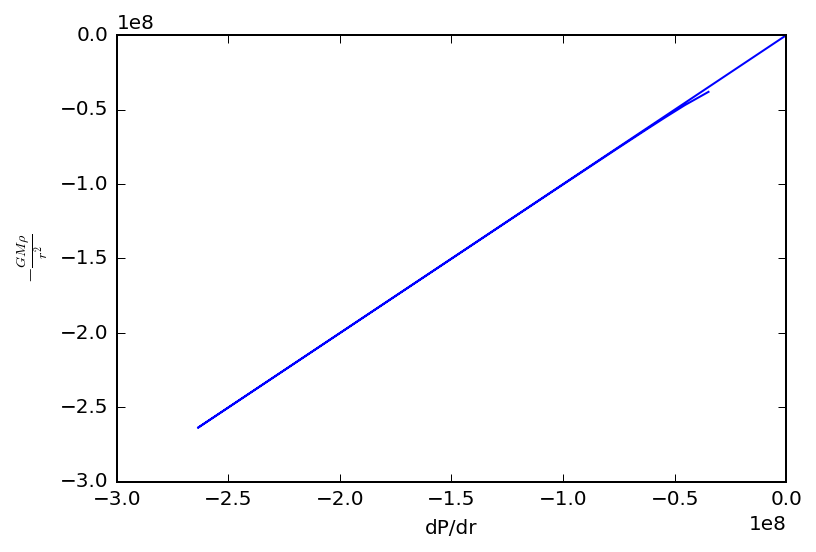

In [6]:
plt.plot(left, right)
plt.xlabel('dP/dr')
plt.ylabel(r'$-\frac{G M \rho}{r^2}$')
plt.show()

Overall the plot is one-to-one, which is in good agreement for the extremely low average absolute error (~0.3%) obtained. This star satisfies hydrostatic equilibrium extremely well.

For radiative energy transport:

$$\frac{dT}{dr} = -\frac{3}{4 a c} \frac{\kappa \rho}{T^3} \frac{L}{4 \pi r^2}$$

In [7]:
left = dT/dr
right = -3/(4*a*c) * kap_avg*rho_avg/T_avg**3 * L_r_avg/(4*np.pi*r_avg**2)

print "The average absolute error is", np.abs(np.mean((left-right)/right))

The average absolute error is 0.183838195846


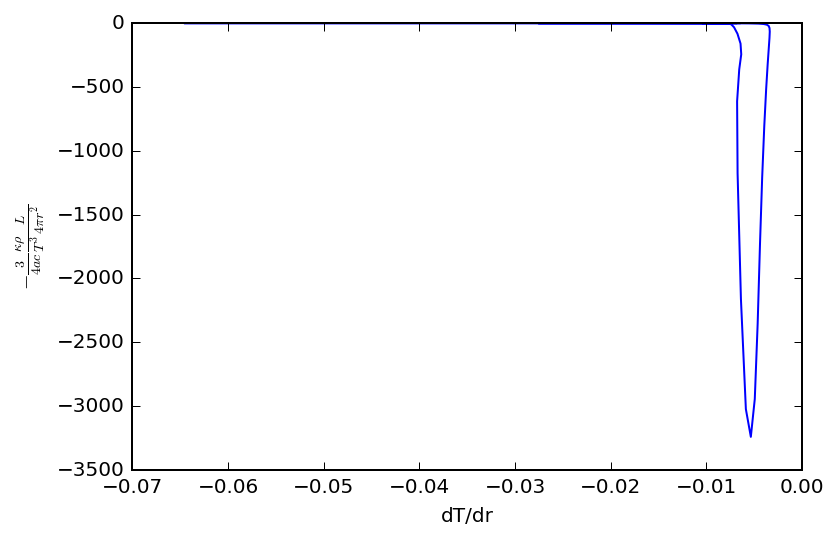

In [8]:
plt.plot(left, right)
plt.xlabel('dT/dr')
plt.ylabel(r'$-\frac{3}{4 a c} \frac{\kappa \rho}{T^3} \frac{L}{4 \pi r^2}$')
plt.show()

Something doesn't look quite right. Playing around with the indexes, if I cut off the first 40 steps of simulated data, I obtain a plot as follows:

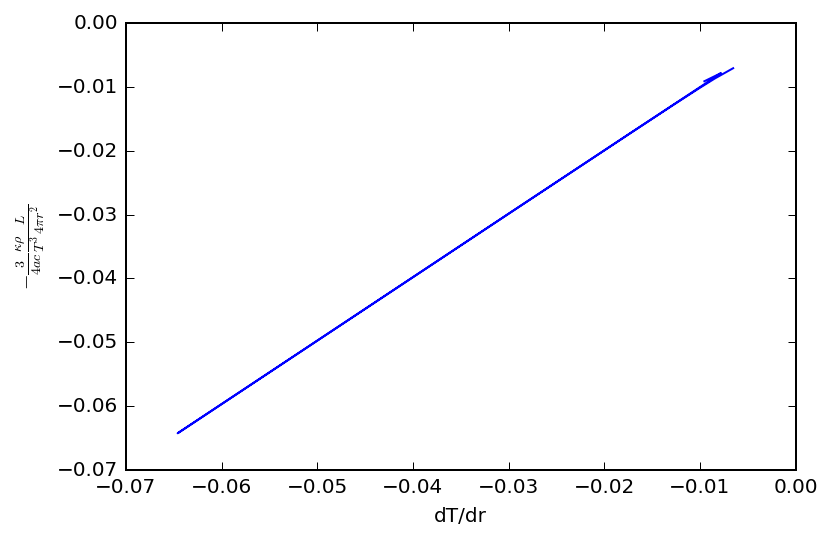

In [9]:
plt.plot(left[41:], right[41:])
plt.xlabel('dT/dr')
plt.ylabel(r'$-\frac{3}{4 a c} \frac{\kappa \rho}{T^3} \frac{L}{4 \pi r^2}$')
plt.show()

This looks much more one-to-one. The wide discrepancy in the first forty or so steps is probably what makes the average absolute error ~20%, which is reasonable but not great. Most likely the discrepancy comes from the unphysically high values of opacity the simulation yielded:

In [10]:
[x for x in kap[:41]]

[0.031799599999999997,
 0.071726747300000004,
 0.182429332,
 0.51296056700000003,
 1.4775201200000001,
 4.0463856500000004,
 9.8091191900000005,
 20.579801,
 38.429398300000003,
 65.179142600000006,
 103.007752,
 156.130169,
 230.51760400000001,
 334.31803400000001,
 478.86004800000001,
 681.228298,
 962.39771499999995,
 1348.71127,
 1876.0490500000001,
 2586.25225,
 3513.6310199999998,
 4669.66219,
 6004.8534600000003,
 7209.8047299999998,
 7736.8094799999999,
 7254.1484099999998,
 4835.1156000000001,
 2898.2204099999999,
 1953.69595,
 1515.05645,
 1292.239,
 926.09950500000002,
 496.76155,
 215.79993099999999,
 89.901491800000002,
 40.046526,
 19.752974399999999,
 11.148452600000001,
 6.92357508,
 4.2740882100000004,
 2.7010885999999998]

I now trace the evolution of a 1 solar-mass star with solar metallicity (Zsun = 0.01 over its lifetime). First, I find the onset of helium burning by looking for a nonzero helium core mass and radius.

In [11]:
ii = np.where(summary['R_He'] > 0)[0][0]
jj = np.where(summary['M_He'] > 0)[0][0]
if (ii == jj):
    print 'The sun starts burning helium when it is '+'{:3e}'.format(age[ii])+' years old.'

The sun starts burning helium when it is 5.645811e+09 years old.


I now find when the sun moves off the main sequence. In order to do so, I look for when there is no hydrogen left for the sun to burn. As a sanity check, I also look for when there is a non-zero central electron degeneracy (http://faculty.wcas.northwestern.edu/~infocom/The%20Website/evolution.html).

In [12]:
jj = np.where(summary['X_c'] == 0)[0][0]
print 'The sun runs out of H to burn and moves off the main sequence when it is '+'{:3e}'.format(age[jj])+' years old.'

print '\nAs a sanity check...'
kk = np.where(summary['psi_c'] > 0)[0][0]
print 'The sun has a non-zero central electron degeneracy starting from '+'{:3e}'.format(age[kk])+' years old.'

The sun runs out of H to burn and moves off the main sequence when it is 8.601837e+09 years old.

As a sanity check...
The sun has a non-zero central electron degeneracy starting from 8.188299e+09 years old.


Fortunately, the ages seem to be within an order of magnitude of each other.

Below are my plots of luminosity, radius, and effective temperature vs age. The black circled point marks when the sun runs out of hydrogen to burn and thus moves off the main sequence.

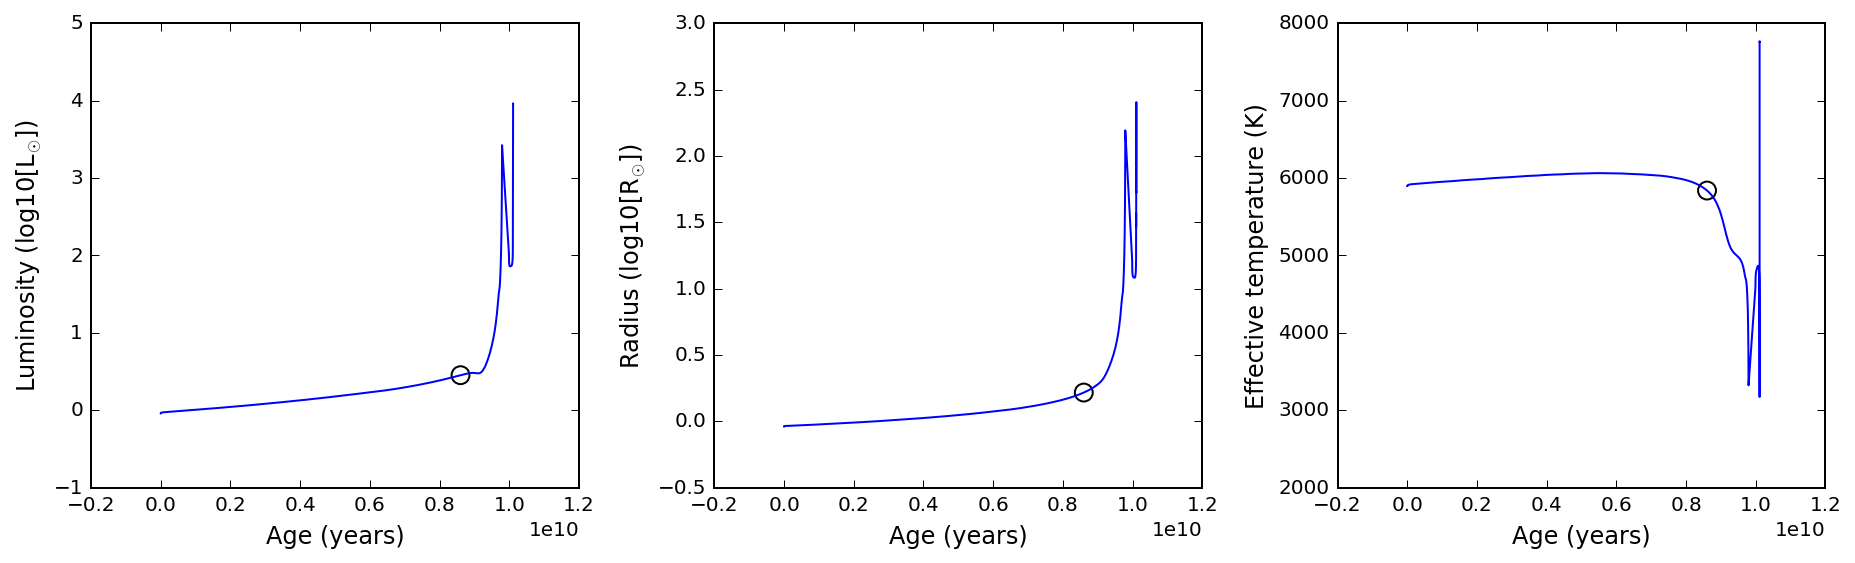

In [13]:
lumin = np.array(summary['Log10(L)'])
radius1 = np.array(summary['Log10(R)'])
temp1 = np.array(summary['Log10(T_s)'])
sigma = 5.670367e-8 # W⋅m−2⋅K−4
radius2 = 10**(radius1)*6.95700e8 # log10(R) (Rsol) -> R (m)
lumin2 = 10**(lumin)*3.828e26 # log10(L) (Lsol) -> L (W)
T_eff = (lumin2/(4*np.pi*radius2**2*sigma))**(1.0/4) # (K)

f, axarr = plt.subplots(1, 3)
for (ax, yarr, ylabel) in zip(axarr, [lumin, radius1, T_eff], 
                              ['Luminosity (log10[L'+r'$_{\odot}$'+'])', 
                               'Radius (log10[R'+r'$_{\odot}$'+'])', 
                               'Effective temperature (K)']):
    ax.plot(age, yarr)
    ax.scatter(age[jj], yarr[jj], s=80, facecolors='none', edgecolors='k')
    ax.set_xlabel('Age (years)', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
f.set_size_inches(13,4)
f.tight_layout()

Below is my plot of the sun's trajectory on the HR diagram.

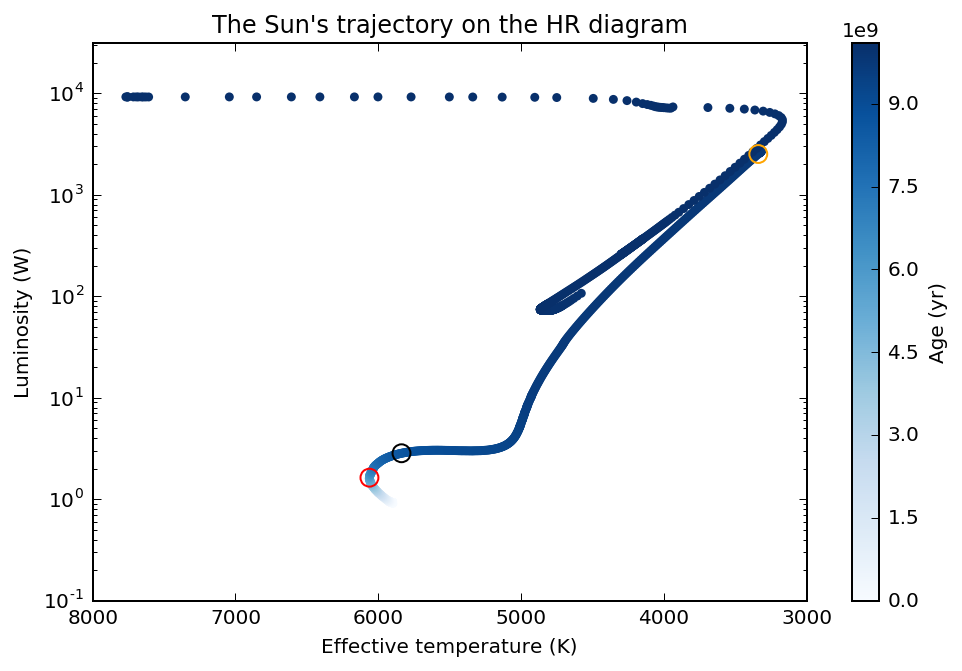

In [14]:
plt.scatter(T_eff, 10**(lumin), c=age, lw=0, cmap=cm.Blues)
plt.yscale('log')
plt.ylim(ymax=10**4.5)
plt.xlim(xmin=3000)
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (W)')
plt.title('The Sun\'s trajectory on the HR diagram')
plt.gca().invert_xaxis()
h = plt.colorbar()
h.set_label('Age (yr)')
plt.gcf().set_size_inches(8,5)
plt.scatter(T_eff[ii], 10**(lumin[ii]), s=80, facecolors='none', edgecolors='r')
plt.scatter(T_eff[jj], 10**(lumin[jj]), s=80, facecolors='none', edgecolors='k')
he1 = np.where(summary['L_3alpha'] > 1)[0][0] # approximately where the helium flash point is
plt.scatter(T_eff[he1], 10**(lumin[he1]), s=80, facecolors='none', edgecolors='orange')
plt.show()

The red circled point marks the onset of hydrogen -> helium burning in the sun. The black circled point again marks when the sun runs out of hydrogen to burn and thus moves off the main sequence onto the red giant branch. 

There's a 'helium flash' point, marked by the orange circle point (found approximately when its solar luminosity due to the triple-alpha process reaches 1). Then the sun moves back down the horizontal branch, until it goes back up the asymptotic giant branch and reaches its planetary nebula stage. We don't see the sun's progression through the planetary nebula stage through its final evolution stages, where it quickly fades into a white dwarf.

Finally, I determine the main sequence lifetime vs mass for stars from 0.5 solar masses to 10 solar masses in steps of 0.5 solar masses. I plot a scatter plot of the relationship - the main sequence lifetime clearly decreases with increasing mass. A table with the values is also printed below.

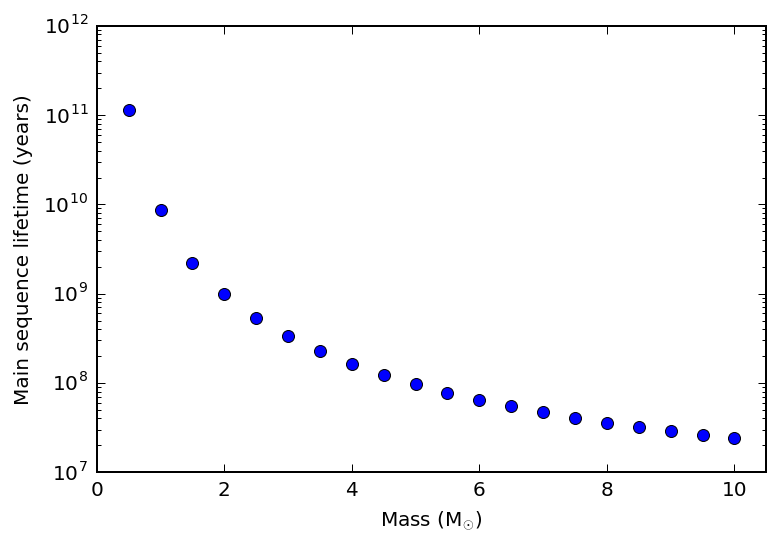

In [15]:
mainseq_lifetime = np.array([])
filename_arr = np.array(['summary_00.5', 'summary_01.0', 'summary_01.5', 'summary_02.0',
                         'summary_02.5', 'summary_03.0', 'summary_03.5', 'summary_04.0',
                         'summary_04.5', 'summary_05.0', 'summary_05.5', 'summary_06.0',
                         'summary_06.5', 'summary_07.0', 'summary_07.5', 'summary_08.0',
                         'summary_08.5', 'summary_09.0', 'summary_09.5', 'summary_10.0'])
for ff in filename_arr:
    summary = asc.read(ff+'.txt', guess=False, delimiter=' ', Reader=asc.FastNoHeader)
    summary = Table(summary, names=summary_cols)
    age = np.array(summary['t'])
    jj = np.where(summary['X_c'] == 0)[0][0]
    mainseq_lifetime = np.append(mainseq_lifetime, age[jj])

xarr = np.arange(0.5,10.5,0.5)
plt.semilogy(xarr, mainseq_lifetime, 'bo')
plt.xlim(xmax=10.5)
plt.xlabel('Mass (M'+r'$_{\odot}$'+')')
plt.ylabel('Main sequence lifetime (years)')
plt.show()

In [16]:
print Table([xarr, mainseq_lifetime], names=['Mass (Msol)', 'Main sequence lifetime (years)'])

Mass (Msol) Main sequence lifetime (years)
----------- ------------------------------
        0.5                 113959225000.0
        1.0                   8601837390.0
        1.5                   2194295480.0
        2.0                    978752517.0
        2.5                    536615088.0
        3.0                    334175359.0
        3.5                    227043899.0
        4.0                    163162084.0
        4.5                    123356824.0
        5.0                     96728866.7
        5.5                     78092942.4
        6.0                     64642790.8
        6.5                     54587101.9
        7.0                     46866455.5
        7.5                     40827652.3
        8.0                     36010299.7
        8.5                     32104303.2
        9.0                     28894754.0
        9.5                     26220491.1
       10.0                     23962538.7


# Project 3: Exoplanets

As I wrote a lot of helper functions for this project that may not be of interest, they are included in an appendix at the end of the section. 

Some reasonable assumptions I made while doing this project:
- Gravitational effects between the three planets can be neglected
- The center of mass of the system is at the parent star
- The true orbits of the three planets are circular; their inclinations makes their orbits look elliptical
- The error given in the code is centered about the data point in question

Below, I read in the provided data, noting that all RA and DEC values and errors are given in terms of arcseconds. Then before I do any calculations, to get a feel of the exoplanet system I am looking at, I first plot the fitted elliptical orbits for all three planets in the system, assuming the parent star is at the center.

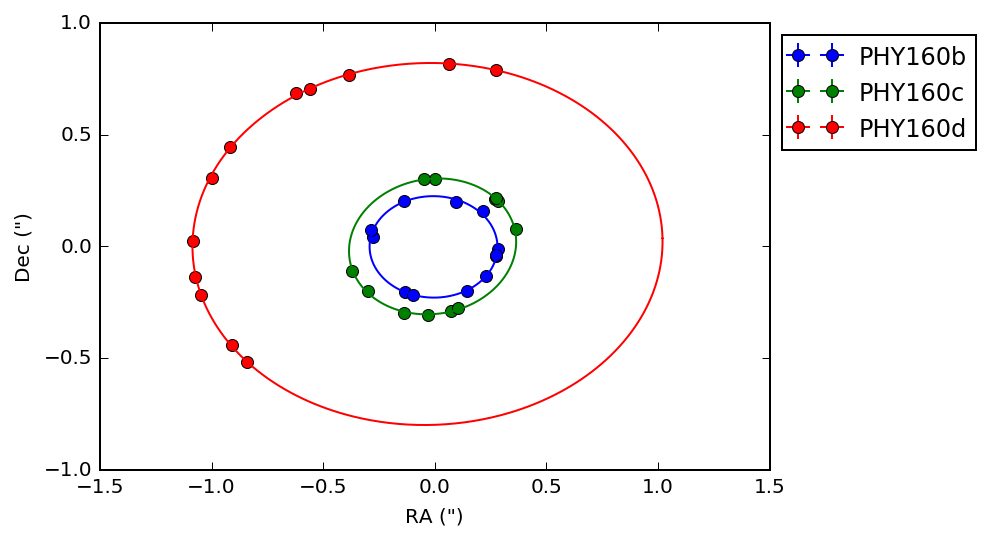

In [24]:
G = astropy.constants.G
Lb_Lstar = 7e-9
Lc_Lstar = 3e-11
Ld_Lstar = 3e-11

data = asc.read('Exoplanet_orbits_positions_(modified).txt', guess=False, delimiter='\t')
data2 = asc.read('exoplanet_orbit_radial_velocities.txt', guess=False, delimiter=' ')

PHY160b = data[:12]
PHY160c = data[12:24]
PHY160d = data[24:]

PHY160b_RA = np.array(PHY160b['RA_(")'])
PHY160b_RA_err = np.array(PHY160b['RA_error_(")'])
PHY160b_Dec = np.array(PHY160b['Dec_(")'])
PHY160b_Dec_err = np.array(PHY160b['Dec_Error_(")'])

PHY160c_RA = np.array(PHY160c['RA_(")'])
PHY160c_RA_err = np.array(PHY160c['RA_error_(")'])
PHY160c_Dec = np.array(PHY160c['Dec_(")'])
PHY160c_Dec_err = np.array(PHY160c['Dec_Error_(")'])

PHY160d_RA = np.array(PHY160d['RA_(")'])
PHY160d_RA_err = np.array(PHY160d['RA_error_(")'])
PHY160d_Dec = np.array(PHY160d['Dec_(")'])
PHY160d_Dec_err = np.array(PHY160d['Dec_Error_(")'])

Date = np.array(data2['Date'])
PHY160a_radial_v = np.array(data2['radial_velocity']) # in m/s

actual_dates = np.array([date(2011,4,23), date(2011,6,27), date(2012,1,3), date(2012,3,16),
                         date(2012,7,1), date(2013,2,12), date(2013,6,2), date(2014,1,31),
                         date(2014,3,16), date(2014,6,27), date(2015,3,11), date(2015,7,5)])

# plotting
plt.errorbar(PHY160b_RA, PHY160b_Dec, xerr=PHY160b_RA_err, yerr=PHY160b_Dec_err,
             fmt='bo', capthick=0, label='PHY160b')
plot_ellipse(PHY160b_RA, PHY160b_Dec, col='b')

plt.errorbar(PHY160c_RA, PHY160c_Dec, xerr=PHY160c_RA_err, yerr=PHY160c_Dec_err,
             fmt='go', capthick=0, label='PHY160c')
plot_ellipse(PHY160c_RA, PHY160c_Dec, col='g')

plt.errorbar(PHY160d_RA, PHY160d_Dec, xerr=PHY160d_RA_err, yerr=PHY160d_Dec_err,
             fmt='ro', capthick=0, label='PHY160d')
plot_ellipse(PHY160d_RA, PHY160d_Dec, col='r')

plt.xlabel('RA (")')
plt.ylabel('Dec (")')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))

plt.show()

## (A) Orbital properties

### 1. Orbital period
In order to find orbital period, I fit a sinusoidal function to the planet's DEC motion as a function of time. From the resulting fit, I obtain a frequency (omega) parameter, from which I can find the orbital period (T = 2\*pi/omega). Uncertainties were found by error propagation, where the frequency error was found from fitting the period using the data with its uncertainty.

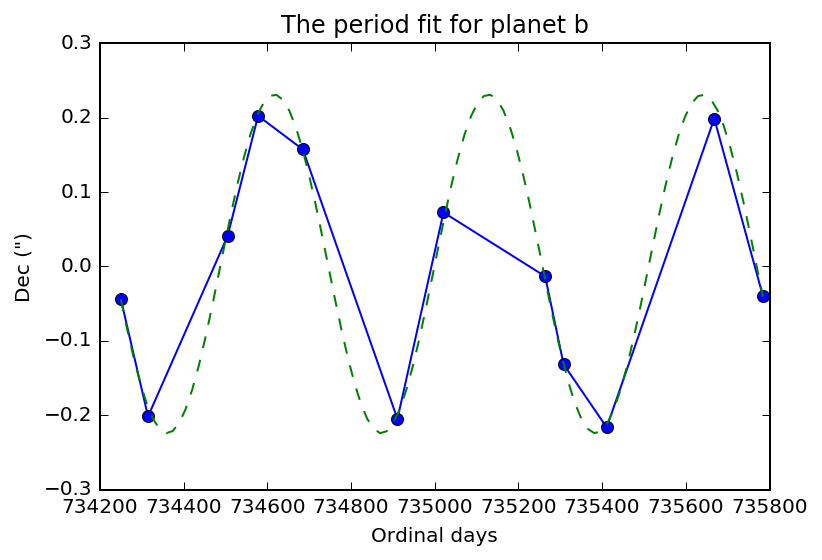

The orbital period of planet b is 511.729627039 +/- 6.27781656614 days.


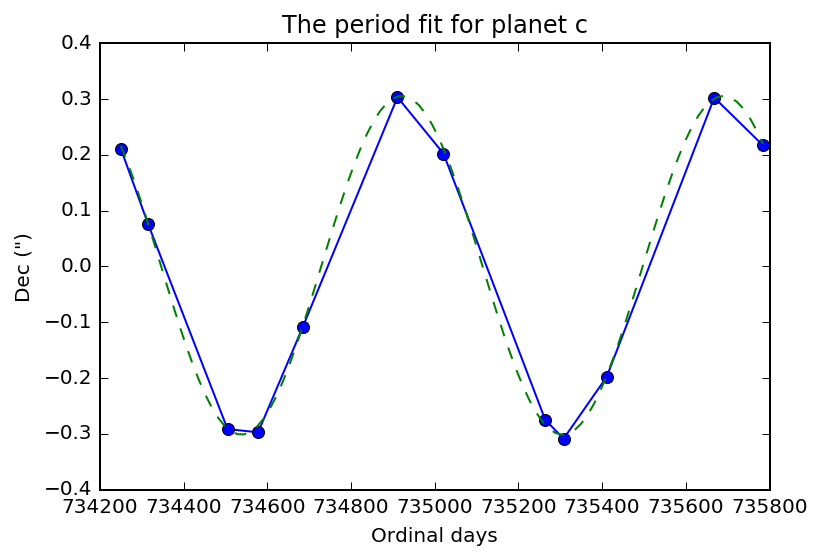

The orbital period of planet c is 767.956384692 +/- 6.27409171403 days.


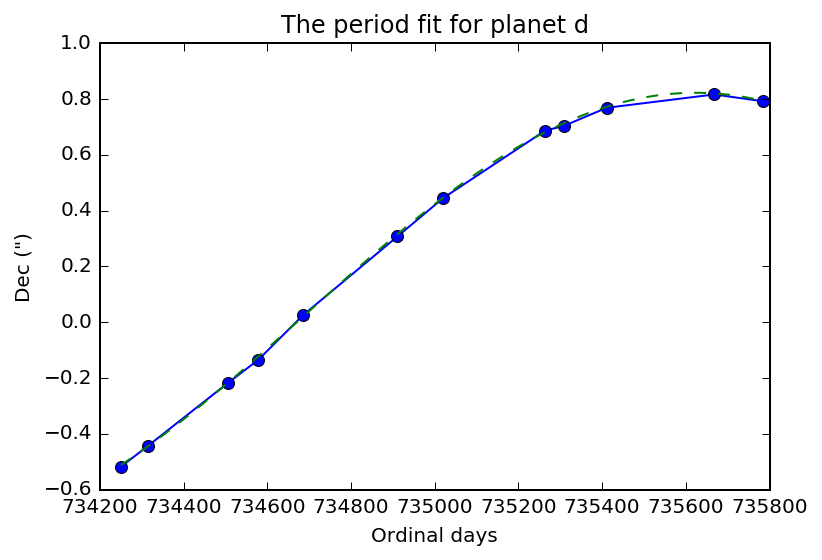

The orbital period of planet d is 3744.91381671 +/- 2.57756278395 days.


In [25]:
Tb, Tb_err = find_orbital_period(PHY160b_RA, PHY160b_Dec, PHY160b_Dec_err, actual_dates,
                                 planet='b')
print "The orbital period of planet b is", Tb, "+/-", Tb_err, "days."

Tc, Tc_err = find_orbital_period(PHY160c_RA, PHY160c_Dec, PHY160c_Dec_err, actual_dates,
                                 planet='c')
print "The orbital period of planet c is", Tc, "+/-", Tc_err, "days."

Td, Td_err = find_orbital_period(PHY160d_RA, PHY160d_Dec, PHY160d_Dec_err, actual_dates,
                                 planet='d')
print "The orbital period of planet d is", Td, "+/-", Td_err, "days."

### 2. Semi-major axis
In order to find the semi-major axis, I used an ellipse-fitting code provided by http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html. This code returns an estimate for the semi-major axis and the semi-minor axis of the fitted ellipse. The physical estimate for the semi-major axis is found by using parallax (since it is given that the star is at a distance of 5.3 pc) and the small angle approximation. Uncertainties were again found by error propagation, where the axis-estimate error was found from fitting the ellipse using the data with its uncertainty.

In [26]:
a_b, a_b_err = find_semimajor_axis(PHY160b_RA, PHY160b_Dec, PHY160b_RA_err, PHY160b_Dec_err)
print "The semi-major axis for planet b is", a_b, "+/-", a_b_err, "AU.\n"

a_c, a_c_err = find_semimajor_axis(PHY160c_RA, PHY160c_Dec, PHY160c_RA_err, PHY160c_Dec_err)
print "The semi-major axis for planet c is", a_c, "+/-", a_c_err, "AU.\n"

a_d, a_d_err = find_semimajor_axis(PHY160d_RA, PHY160d_Dec, PHY160d_RA_err, PHY160d_Dec_err)
print "The semi-major axis for planet d is", a_d, "+/-", a_d_err, "AU."

The semi-major axis for planet b is 1.51876023394 +/- 0.000950519216601 AU.

The semi-major axis for planet c is 1.9937626025 +/- 0.0058610238845 AU.

The semi-major axis for planet d is 5.58181892313 +/- 0.0247417953328 AU.


### 3. Orbital inclination
In order to find the orbital inclination, I found the semi-major and semi-minor axes detailed in section 2 above and took advantage of the assumption that the planets' orbits were circular, and the angle of inclination was what made them appear elliptical. I followed the trigonometric argument seen in Maoz Figure 2.9.

In [27]:
i_b, i_b_err = find_orb_inclination(PHY160b_RA, PHY160b_Dec, PHY160b_RA_err, PHY160b_Dec_err)
print "The orbital inclination for planet b is", i_b, "+/-", i_b_err, "degrees.\n"

i_c, i_c_err = find_orb_inclination(PHY160c_RA, PHY160c_Dec, PHY160c_RA_err, PHY160c_Dec_err)
print "The orbital inclination for planet c is", i_c, "+/-", i_c_err, "degrees.\n"

i_d, i_d_err = find_orb_inclination(PHY160d_RA, PHY160d_Dec, PHY160d_RA_err, PHY160d_Dec_err)
print "The orbital inclination for planet d is", i_d, "+/-", i_d_err, "degrees."

The orbital inclination for planet b is 37.5113269306 +/- 0.17250914027 degrees.

The orbital inclination for planet c is 36.5041210646 +/- 0.232153509897 degrees.

The orbital inclination for planet d is 39.6563876755 +/- 0.401571734059 degrees.


### 4. Mass of the parent star
The mass of the parent star based on an orbiting planet was found using Newtonian mechanics -- assuming the planets don't interact with each other and orbit around the star (also assuming the parent star is the center of mass of this exoplanet system). The final mass estimate was found by averaging the three planet-based estimates. Uncertainties were found using error propagation.

In [28]:
m1, m1_err = find_parent_star_mass(a_b, a_b_err, Tb, Tb_err)
print "The mass of the parent star based on planet b is", m1, "+/-", m1_err, "solar masses."
m2, m2_err = find_parent_star_mass(a_c, a_c_err, Tc, Tc_err)
print "The mass of the parent star based on planet c is", m2, "+/-", m2_err, "solar masses."
m3, m3_err = find_parent_star_mass(a_d, a_d_err, Td, Td_err)
print "The mass of the parent star based on planet d is", m3, "+/-", m3_err, "solar masses.\n"

Mstar = (m1+m2+m3)/3.0
Mstar_err = np.sqrt(m1_err**2 + m2_err**2 + m3_err**2)

print "The final mass estimate of the parent star is", Mstar, "+/-", Mstar_err, "solar masses."

The mass of the parent star based on planet b is 1.78427836253 +/- 0.0439064715453 solar masses.
The mass of the parent star based on planet c is 1.79235200416 +/- 0.0332799533063 solar masses.
The mass of the parent star based on planet d is 1.65393963903 +/- 0.0221111328218 solar masses.

The final mass estimate of the parent star is 1.74352333524 +/- 0.0593652737742 solar masses.


## (B) Planet properties

To estimate the **radius of the planets**, I use a geometric argument combined with the given brightness ratios of the planet to the parent star:

$$A \frac{\pi r_{p}^2}{4 \pi a^2} = \frac{L_p}{L_{star}}$$

Above, A is the albedo; thus, we can solve this equation to find the radius of the planet once we estimate what the albedo is. 

As I clearly live in a pre-Copernican world where the Universe revolves around Earth, I first use the albedo of Earth, A = 0.3 (https://earthobservatory.nasa.gov/IOTD/view.php?id=84499). Since A ranges from 0 to 1, the resulting radius estimate will be on the same order of magnitude.

In [29]:
find_rplanet(a_b, a_b_err, Lb_Lstar, 'b')
find_rplanet(a_c, a_c_err, Lc_Lstar, 'c')
find_rplanet(a_d, a_d_err, Ld_Lstar, 'd')

The radius of planet b is 69411.7538073 +/- 65.9772058518 km.
The radius of planet c is 5965.2528003 +/- 34.9624891396 km.
The radius of planet d is 16700.5645107 +/- 413.201949066 km.


Since out of the three exoplanets, planet b clearly dominates the mass of the solar system, I estimate the **mass of planet b** using the radial velocities of the planet star.

To best find the "wobble velocity" from the given radial velocities, I again fit a sinusoidal curve to find the best amplitude fit. I then use Kepler's Third Law (as modified by Newton) to find what the mass of the planet is:

$$m_{planet} v_{planet} = m_{star} v_{star}$$

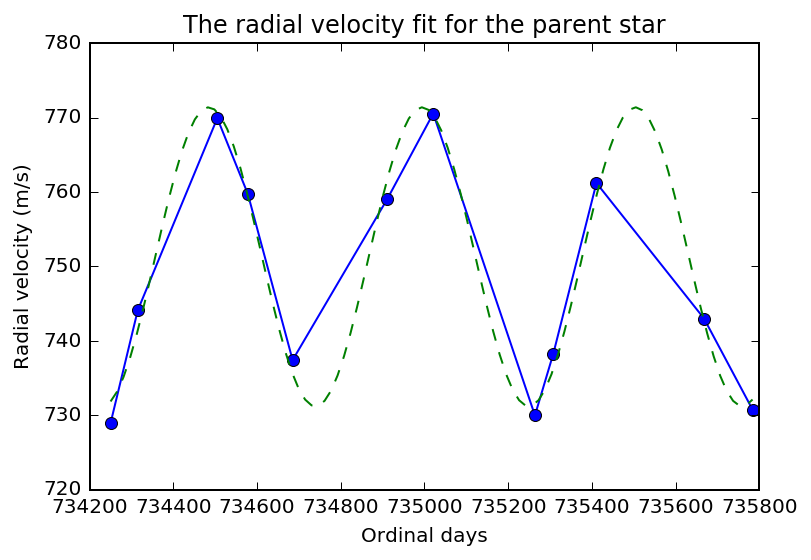

The mass of planet b is 1.95515084896 +/- 0.0744311382381 Jupiter masses.


In [30]:
Vstar = PHY160a_radial_v * u.meter / u.second
Vplanet = (np.sqrt(G.value * (Mstar)/(a_b)))
Vplanet_err = np.sqrt(G.value/(4*Mstar*a_b)*Mstar_err**2 + (G.value*Mstar)/(4*a_b**3)*a_b_err**2)
# in physical units, now
Vplanet = (Vplanet * np.sqrt(1 * G.unit * u.solMass / u.AU)).to(u.m / u.s)
Vplanet_err = (Vplanet_err * np.sqrt(1 * G.unit * u.solMass / u.AU)).to(u.m / u.s)

x = np.array([x.toordinal() for x in actual_dates])
y = Vstar

fit = lambda p, x: p[0]*np.sin(p[1]*x + p[2]) + p[3]
err = lambda p, x, y: fit(p,x) - y
# initial guess
amp = ((np.max(Vstar) - np.min(Vstar)).value)/2
offset = np.mean(Vstar).value
ii1, ii2 = 0, len(PHY160b_RA)-1
num_cycles = find_num_cycles(PHY160b_RA, PHY160b_Dec, ii1, ii2)
omega = (num_cycles*2*np.pi)/(actual_dates[ii2] - actual_dates[ii1]).days # rad/days
p0 = [amp,omega,-np.pi/2,offset]
# calls optimize.leastsq to find optimal parameters
p, success = optimize.leastsq(err, p0, args=(np.array(x), np.array(y)), ftol=5e-9, xtol=5e-9)

plt.plot(x, Vstar, 'bo-')
x1 = np.linspace(x[0], x[-1], 100)
plt.plot(x1, p[0]*np.sin(p[1]*x1 + p[2]) + p[3], 'g--')
plt.title('The radial velocity fit for the parent star')
plt.xlabel('Ordinal days')
plt.ylabel('Radial velocity (m/s)')
plt.show()

Vstar_ampl1 = p0[0] * (u.m / u.s)
Vstar_ampl = Vstar_ampl1/np.sin(i_b * np.pi/180) # adjusting for inclination
Mplanet = Mstar*Vstar_ampl/Vplanet
Mplanet_err = np.sqrt(Vstar_ampl**2/Vplanet**2*Mstar_err**2 +
                      Mstar**2*Vstar_ampl**2/Vplanet**4*Vplanet_err**2)

# with units now
Mplanet = (((Mstar * u.solMass) * Vstar_ampl / Vplanet)).to(u.jupiterMass)
Mplanet_err = (Mplanet_err * u.solMass).to(u.jupiterMass).value

print 'The mass of planet b is '+str(Mplanet.value)+' +/- '+str(Mplanet_err)+' Jupiter masses.'

### Appendix for code used in Project 3

In [17]:
# code for fitting an ellipse below in this segment from http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

from numpy.linalg import eig, inv
def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a


def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2


def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [18]:
def plot_ellipse(RA, DEC, col='b', show=True):
    '''
    Fits and plots an ellipse given the RA and DEC parameters.
    
    Returns the semi-major and semi-minor axes from the ellipse fit.
    '''
    a = fitEllipse(RA, DEC)
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation2(a)
    axes = ellipse_axis_length(a)

    R = np.arange(0,2*np.pi, 0.01)
    a, b = axes
    xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
    yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)

    if show != False:
        plt.plot(xx, yy, col)
    
    return a,b

def find_num_cycles(RA, DEC, ii1, ii2):
    '''
    Looks for the number of cycles between the two observations that are closest 
    together in space.
    
    Each cycle looks roughly like -sin(t).
    '''
    ra_val = RA[ii1]
    dec_val = DEC[ii1]
    
    if dec_val > 0: 
        num_cycles = 0
    else: 
        num_cycles = 1
    
    for ii in np.arange(ii1, ii2):
        if RA[ii] < ra_val and DEC[ii] < dec_val and DEC[ii-1] > min(0, dec_val):
            num_cycles += 1
    return num_cycles

In [19]:
def find_orbital_period(RA, DEC, DEC_err, actual_dates, planet='planet'):
    '''
    Finds the orbital period based on the passed in RA and DEC of the planet by fitting a
    sin curve using optimize.leastsq. The corresponding uncertainty is found using error
    propagation.
    
    Returns the orbital period and corresponding +/- uncertainty.
    '''
    ii1, ii2 = 0, len(RA)-1
    num_cycles = find_num_cycles(RA, DEC, ii1, ii2)

    x = np.array([x.toordinal() for x in actual_dates])
    y = DEC
    
    fit = lambda p, x: p[0]*np.sin(p[1]*x + p[2]) + p[3]
    err = lambda p, x, y: fit(p,x) - y

    # initial guess
    amp = ((np.max(DEC) - np.min(DEC)))/2
    offset = np.mean(DEC)
    omega = (num_cycles*2*np.pi)/(actual_dates[ii2] - actual_dates[ii1]).days # rad/days
    p0 = [amp,omega,0,offset]

    # calls optimize.leastsq to find optimal parameters
    p, success = optimize.leastsq(err, p0, args=(np.array(x), np.array(y)), ftol=5e-9, xtol=5e-9)
    period = 2*np.pi/p[1]
    
    ## now for uncertainty:
    y = DEC+DEC_err/2

    fit = lambda p, x: p[0]*np.sin(p[1]*x + p[2]) + p[3]
    err = lambda p, x, y: fit(p,x) - y
    # initial guess
    amp = ((np.max(DEC+DEC_err/2) - np.min(DEC+DEC_err/2)))/2
    offset = np.mean(DEC+DEC_err/2)
    omega = (num_cycles*2*np.pi)/(actual_dates[ii2] - actual_dates[ii1]).days # rad/days
    p0 = [amp,omega,0,offset]
    
    # calls optimize.leastsq to find optimal parameters
    p, success = optimize.leastsq(err, p0, args=(np.array(x), np.array(y)), ftol=5e-9, xtol=5e-9)
    
    # error is found using error propagation:
    #  T_err = 2*pi/omega * omega_err
    period_err = 2*np.pi/omega*p[1]
    
    plt.plot(x, DEC, 'bo-')
    x1 = np.linspace(x[0], x[-1], 100)
    plt.plot(x1, p[0]*np.sin(p[1]*x1 + p[2]) + p[3], 'g--')
    plt.title('The period fit for planet '+planet)
    plt.xlabel('Ordinal days')
    plt.ylabel('Dec (")')
    plt.show()

    return period, period_err

In [20]:
def find_semimajor_axis(RA, DEC, RA_err, DEC_err):
    '''
    Finds the semi-major axis based on the passed in RA and DEC of the planet by fitting 
    an ellipse using code provided by Nicky van Foreest. The corresponding uncertainty is
    found using error propagation.
    
    Returns the semi-major axis and corresponding +/- uncertainty.    
    '''
    a,b = plot_ellipse(RA, DEC, show=False)
    # using parallax
    alpha = a #arcsec
    d = 5.3 #pc

    ra_err = RA+(RA_err/2)
    dec_err = DEC+(DEC_err/2)
    a2,b2 = plot_ellipse(ra_err, dec_err, show=False)

    # using error propagation
    a_err = np.abs(a2-a)
    b_err = np.abs(b2-b)

    sm_axis = d*alpha # AU
    sm_axis_err = d*a_err
    
    return sm_axis, sm_axis_err

In [21]:
def find_orb_inclination(RA, DEC, RA_err, DEC_err):
    '''
    Finds the orbital inclination based on the passed in RA and DEC of the planet by fitting
    an ellipse using code provided by Nicky van Foreest. The semi-major and semi-minor axes
    estimates were used to find the orbital inclination using a trigonometric argument, as
    seen in Maoz Figure 2.9.
    
    The corresponding uncertainty is found using error propagation.
    
    Returns the semi-major axis and corresponding +/- uncertainty.    
    '''
    a,b = plot_ellipse(RA, DEC, show=False)
    d = 5.3 #pc
    
    ra_err = RA+(RA_err/2)
    dec_err = DEC+(DEC_err/2)
    a2,b2 = plot_ellipse(ra_err, dec_err, show=False)

    a_err = np.abs(a2-a)
    b_err = np.abs(b2-b)

    sm_axis = d*a # AU
    sm_axis_err = d*a_err
    
    # using error propagation
    orb_incl = np.arccos(b/a)*(180/np.pi) # degrees
    orb_incl_err = np.sqrt(1/(a**2*(1-b**2/a**2))*b_err**2 +
                           b**2/(a**4*(1-b**2/a**2))*a_err**2) * (180/np.pi)
    
    return orb_incl, orb_incl_err

In [22]:
def find_parent_star_mass(sm_axis, sm_axis_err, T, T_err):
    '''
    Estimates the mass of the parent star using Newtonian mechanics. Uncertainties found
    using error propagation.
    
    Returns a Mstar estimate in terms of Msol, and a Mstar uncertainty.
    '''
    Mstar = ((4*np.pi**2*(sm_axis * u.AU)**3)/((T * u.day)**2*G)).to(u.kg) # kg
    Mstar_err = np.sqrt((144*np.pi**4*sm_axis**4)/(G**2*T**4)*sm_axis_err**2 + 
                        (64*np.pi**4*sm_axis**6)/(G**2*T**6)*T_err**2)
    M_star_err = (Mstar_err * (u.AU)**3/(u.day)**2).to(u.solMass).value
    
    return (Mstar).to(u.solMass).value, M_star_err

In [23]:
def find_rplanet(sm_axis, sm_axis_err, Lp_Lstar, planet):
    '''
    Finds the radius of the planet using the geometric argument in part (B). 
    Uncertainties found using error propagation.
    
    Prints the radius estimate with its uncertainties.
    '''
    A = 0.3
    r = 2*(sm_axis)*np.sqrt(Lp_Lstar/A) * u.AU
    r_err = r * sm_axis_err
    print "The radius of planet "+planet+" is "+str(
        (r).to(u.km).value)+" +/- "+str((r_err).to(u.km))+"."